In [1]:
# Useful starting lines
%matplotlib inline

import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import time


%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from helpers_own import *

Import data -> use of the imported function made by the ML team (takes a long time)

In [166]:
from helpers import load_csv_data

x_train, x_test, y_train, train_ids, test_ids = load_csv_data("./dataset", sub_sample=False)

This method allows us to take a specific feature out of X. My idea is to take a few of the interesting features out and concatenate them together.

In [167]:
def read_first_line(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        first_line = next(reader)
        return first_line
        
def extract_feature(name):
    filename = './dataset/x_train.csv'
    first_line = np.array(read_first_line(filename))
    index = np.where(first_line == name)
    ind = index[0].item()
    return x_train.copy()[:, ind-1]

Here is a quick method to see that our data is not "clean". There are a lot of nan.

In [168]:
def caracteristics(x, y):
    count = np.sum(~np.isnan(x))
    print("Number of x features beeing not nan:", count)
    nan_count = np.sum(np.isnan(x))
    print("Number of x features beeing nan:", nan_count)
    num_negatives = np.sum(y == -1)
    print("Number of y -1s:", num_negatives)
    num_positives = np.sum(y == 1)
    print("Number of y 1s:", num_positives)
    num_null = np.sum(y == 0)
    print("Number of y 0s:", num_null)
    nan_count_y = np.sum(np.isnan(y))
    print("Number of y nan:", nan_count_y)

#Here is for the specific feature "_BMI5"
caracteristics(x_train,y_train)

Number of x features beeing not nan: 58155556
Number of x features beeing nan: 47175779
Number of y -1s: 299160
Number of y 1s: 28975
Number of y 0s: 0
Number of y nan: 0


Now we are ready to extract a few features and replace the lack of data with the mean (those features are taken from the website: https://medium.com/@alexteboul17/building-predictive-models-for-heart-disease-using-the-2015-behavioral-risk-factor-surveillance-b786368021ab

In [169]:
testing = extract_feature('_RFCHOL')
np.unique(testing)

array([ 1.,  2.,  9., nan])

In [324]:
def replace_mean(x):
    mean_value = np.nanmean(x)
    x_new = x.copy()
    x_new[np.isnan(x_new)] = mean_value
    return x_new

def replace_mode(x):
    unique, counts = np.unique(x[~np.isnan(x)], return_counts=True)
    mode_value = unique[np.argmax(counts)]
    # Step 2: Replace NaN values with the mode
    x[np.isnan(x)] = mode_value
    return x


################Body mass idex - continuous feature
_BMI5 = extract_feature('_BMI5')
_BMI5 = replace_mean(_BMI5)
_BMI5, _BMI5_mean, _BMI5_std = standardize(_BMI5)


################High blood pressure - categorical feature (1 = no, 2 = yes, 9 = missing)
_RFHYPE5 = extract_feature('_RFHYPE5')
_RFHYPE5[_RFHYPE5 == 9] = np.nan
_RFHYPE5[_RFHYPE5 == 1] = 0
_RFHYPE5[_RFHYPE5 == 2] = 1
_RFHYPE5 = replace_mode(_RFHYPE5)

################High cholesterol - categorical feature (1 = no, 2 = yes, 9 = missing)
_RFCHOL = extract_feature('_RFCHOL')
_RFCHOL[_RFCHOL == 9] = np.nan
_RFCHOL[_RFCHOL == 1] = 0
_RFCHOL[_RFCHOL == 2] = 1
_RFCHOL = replace_mode(_RFCHOL)

################Smoking status - categorical feature (1 = every day, 2 = some days, 3 = formerly, 4 = never, 9 = missing)
_SMOKER3 = extract_feature('_SMOKER3')
_SMOKER3[_SMOKER3 == 9] = np.nan
_SMOKER3 = replace_mode(_SMOKER3)
_SMOKER3, _SMOKER3_mean, _SMOKER3_std = standardize(_SMOKER3)

################Has ever had a stroke  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
CVDSTRK3 = extract_feature('CVDSTRK3')
CVDSTRK3[CVDSTRK3 == 9] = np.nan
CVDSTRK3[CVDSTRK3 == 7] = np.nan
CVDSTRK3[CVDSTRK3 == 2] = 0
CVDSTRK3 = replace_mode(CVDSTRK3)

################Cholesterol checked  - categorical feature (1 = within the last 5 years, 2 = more than 5 years ago, 3 = never, 9 = missing)
_CHOLCHK = extract_feature('_CHOLCHK')
_CHOLCHK[_CHOLCHK == 9] = np.nan
_CHOLCHK = replace_mode(_CHOLCHK)
_CHOLCHK,_ , _ = standardize(_CHOLCHK)

################Has ever had diabetes  - categorical feature (1 = yes, 2 = yes*, 3 = no, 4 = no - pre-diabetes, 7 = don't know, 9 = missing)
DIABETE3 = extract_feature('DIABETE3')
DIABETE3[DIABETE3 == 9] = np.nan
DIABETE3[DIABETE3 == 7] = np.nan
DIABETE3[DIABETE3 == 3] = 0
DIABETE3[DIABETE3 == 4] = 0
DIABETE3[DIABETE3 == 2] = 1
DIABETE3 = replace_mode(DIABETE3)

################Physical activity index  - categorical feature (1 = highly active, 2 = active, 3 = insufficiently active, 4 = inactive, 9 = missing)
_PACAT1 = extract_feature('_PACAT1')
_PACAT1[_PACAT1 == 9] = np.nan
_PACAT1 = replace_mode(_PACAT1)
_PACAT1, _PACAT1_mean, _PACAT1_std = standardize(_PACAT1)

################Total fruits consumed per day  - continuous feature (implied 2 dp)
#_FRUTSUM = extract_feature('_FRUTSUM')

################Total vegetables consumed per day  - continuous feature (implied 2 dp)
#_VEGESUM = extract_feature('_VEGESUM')

################Computed number of drinks of alcohol beverages per week  - continuous feature (99900 = missing)
_DRNKWEK = extract_feature('_DRNKWEK')
_DRNKWEK[_DRNKWEK == 99900] = np.nan
_DRNKWEK = replace_mean(_DRNKWEK)
_DRNKWEK, _DRNKWEK_mean, _DRNKWEK_std = standardize(_DRNKWEK)

################Have any healthcare coverage  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
HLTHPLN1 = extract_feature('HLTHPLN1')
HLTHPLN1[HLTHPLN1 == 9] = np.nan
HLTHPLN1[HLTHPLN1 == 7] = np.nan
HLTHPLN1[HLTHPLN1 == 2] = 0
HLTHPLN1 = replace_mode(HLTHPLN1)

################Could not see doctor because of cost  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
MEDCOST = extract_feature('MEDCOST')
MEDCOST[MEDCOST == 9] = np.nan
MEDCOST[MEDCOST == 7] = np.nan
MEDCOST[MEDCOST == 2] = 0
MEDCOST = replace_mode(MEDCOST)

################General health status  - categorical feature (1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor, 7 = don't know, 9 = missing)
GENHLTH = extract_feature('GENHLTH')
GENHLTH[GENHLTH == 9] = np.nan
GENHLTH[GENHLTH == 7] = np.nan
GENHLTH = replace_mode(GENHLTH)
GENHLTH, GENHLTH_mean, GENHLTH_std = standardize(GENHLTH)

################Number of days mental health not good  - continuous feature (88 = none, 77 = don't know, 99 = refused)
MENTHLTH = extract_feature('MENTHLTH')
MENTHLTH[MENTHLTH == 88] = 0
MENTHLTH[MENTHLTH == 77] = np.nan
MENTHLTH[MENTHLTH == 99] = np.nan
MENTHLTH = replace_mean(MENTHLTH)
MENTHLTH, MENTHLTH_mean, MENTHLTH_std = standardize(MENTHLTH)

################Number of days physical health not good  - continuous feature (88 = none, 77 = don't know, 99 = refused)
PHYSHLTH = extract_feature('PHYSHLTH')
PHYSHLTH[PHYSHLTH == 88] = 0
PHYSHLTH[PHYSHLTH == 77] = np.nan
PHYSHLTH[PHYSHLTH == 99] = np.nan
PHYSHLTH = replace_mean(PHYSHLTH)
PHYSHLTH, PHYSHLTH_mean, PHYSHLTH_std = standardize(PHYSHLTH)

################Difficulty walking or climbing stairs - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
DIFFWALK = extract_feature('DIFFWALK')
DIFFWALK[DIFFWALK == 9] = np.nan
DIFFWALK[DIFFWALK == 7] = np.nan
DIFFWALK[DIFFWALK == 2] = 0
DIFFWALK = replace_mode(DIFFWALK)

################Sex - categorical feature (1 = male, 2 = female)
SEX = extract_feature('SEX')
SEX[SEX == 2] = 0
SEX = replace_mode(SEX)

################Age  - categorical feature (1 = 18-24, ... 13 = 80+, 14 = missing)
_AGEG5YR = extract_feature('_AGEG5YR')
_AGEG5YR[_AGEG5YR == 14] = np.nan
_AGEG5YR = replace_mode(_AGEG5YR)
_AGEG5YR, _AGEG5YR_mean, _AGEG5YR_std = standardize(_AGEG5YR)

################Education  - categorical feature (1 = none, ... 6 = college grad, 9 = missing)
EDUCA = extract_feature('EDUCA')
EDUCA[EDUCA == 9] = np.nan
EDUCA = replace_mode(EDUCA)
EDUCA, EDUCA_mean, EDUCA_std = standardize(EDUCA)

################Income level  - categorical feature (1 = low, ... 5 = high, 9 = missing)
_INCOMG = extract_feature('_INCOMG')
_INCOMG[_INCOMG == 9] = np.nan
_INCOMG = replace_mode(_INCOMG)
_INCOMG, _INCOMG_mean, _INCOMG_std = standardize(_INCOMG)

################BMI x age
BMIxAGE = _BMI5 * _AGEG5YR
BMIxAGE, BMIxAGE_mean, BMIxAGE_std = standardize(BMIxAGE)

################Age2
AGE2 = _AGEG5YR ** 2
AGE2, AGE2_mean, AGE2_std = standardize(AGE2)

################Age3
AGE3 = _AGEG5YR ** 3
AGE3, AGE3_mean, AGE3_std = standardize(AGE3)

################Drink2
DRNK2 = _DRNKWEK ** 2
DRNK2, DRNK2_mean, DRNK2_std = standardize(DRNK2)

################Physhealth2
PHYSHLTH2 = PHYSHLTH ** 2
PHYSHLTH2, PHYSHLTH2_mean, PHYSHLTH2_std = standardize(PHYSHLTH2)

################Menthealth2
MENTHLTH2 = MENTHLTH ** 2
MENTHLTH2, MENTHLTH2_mean, MENTHLTH2_std = standardize(MENTHLTH2)

################CHOLxHYPE
CHOLxHYPE = _RFCHOL * _RFHYPE5

# TRIED TO ADD INTERACTIONS and POLYNOMIALS, DIDN'T SEEM TO IMPROVE THE MODEL

#Here we stack the features together to have the our new X
X = np.hstack((_BMI5.reshape(-1, 1), _RFHYPE5.reshape(-1, 1), _RFCHOL.reshape(-1, 1), _SMOKER3.reshape(-1, 1), CVDSTRK3.reshape(-1, 1), 
               _CHOLCHK.reshape(-1, 1), DIABETE3.reshape(-1, 1), _PACAT1.reshape(-1, 1), # _FRUTSUM.reshape(-1, 1), _VEGESUM.reshape(-1, 1), 
               _DRNKWEK.reshape(-1, 1), HLTHPLN1.reshape(-1, 1), MEDCOST.reshape(-1, 1), GENHLTH.reshape(-1, 1), MENTHLTH.reshape(-1, 1), PHYSHLTH.reshape(-1, 1), 
               DIFFWALK.reshape(-1, 1), SEX.reshape(-1, 1), _AGEG5YR.reshape(-1, 1), EDUCA.reshape(-1, 1), _INCOMG.reshape(-1, 1)))#,
               #BMIxAGE.reshape(-1, 1), AGE2.reshape(-1, 1), AGE3.reshape(-1, 1), DRNK2.reshape(-1, 1), PHYSHLTH2.reshape(-1, 1), MENTHLTH2.reshape(-1, 1), CHOLxHYPE.reshape(-1, 1)))


In [325]:
np.unique(_RFCHOL)

array([0., 1.])

In [326]:
caracteristics(X, y_train)

Number of x features beeing not nan: 6234565
Number of x features beeing nan: 0
Number of y -1s: 299160
Number of y 1s: 28975
Number of y 0s: 0
Number of y nan: 0


In [327]:
nan_count_per_column = np.sum(np.isnan(X), axis=0)

In [328]:
nan_count_per_column

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [329]:
print(X.shape)
print(y_train.shape)

(328135, 19)
(328135,)


Here I just wanted to use the functions used in the exercise sessions. So I change from -1 to 0 for y negative so that I can use them

In [330]:
#Change all the elements with -1 by 0
y_train_working = y_train.copy()
y_train_working[y_train_working == -1] = 0
#Make y have the correct shape
y_train_working = y_train_working.reshape(-1, 1)

In [331]:
def drop_nan(X, y):
    mask = ~np.isnan(X).any(axis=1)
    X = X[mask]
    y = y[mask]
    return X, y

X, y_train_working = drop_nan(X, y_train_working)
caracteristics(X, y_train_working)

Number of x features beeing not nan: 6234565
Number of x features beeing nan: 0
Number of y -1s: 0
Number of y 1s: 28975
Number of y 0s: 299160
Number of y nan: 0


We split the data into train and val sets

In [363]:
def split_train_val(x, y, k_fold, k):
    k_indices = build_k_indices(y, k_fold) 
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    return x_tr, x_te, y_tr, y_te

np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X_shuffled = X[indices]
y_train_working_shuffled = y_train_working[indices]

X_train, X_val, Y_train, Y_val = split_train_val(X, y_train_working, 10, 9)
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(295317, 19)
(32813, 19)
(295317, 1)
(32813, 1)


We now balance the data

In [364]:
def balance_data(x, y):
    #Balance the data by taking only a certain number of values in y=-1 s.t. the number of y=1 equals the number of y=-1
    
    indices_y_equals_1 = np.where(y == 1)[0]
    indices_y_equals_0 = np.where(y == 0)[0]
    num_positives = np.sum(y == 1)
    num_negatives = np.sum(y == 0)
    selected_indices_neg = np.random.choice(indices_y_equals_0, size=num_positives, replace=False)
    
    selected_indices = np.concatenate((selected_indices_neg, indices_y_equals_1))
    selected_X = x[selected_indices]
    selected_y = y[selected_indices]
    
    return selected_X, selected_y

def balance_data_multiplier(X, y): 
    class_1 = X[y == 1]
    class_0 = X[y == 0]
    count_class_1 = class_1.shape[0]
    count_class_0 = class_0.shape[0]
    num_to_duplicate = count_class_0 - count_class_1
    duplicated_samples = np.tile(class_1, (num_to_duplicate // count_class_1 + 1, 1))[:num_to_duplicate]
    X_balanced = np.vstack((X, duplicated_samples))
    y_balanced = np.hstack((y, np.ones(num_to_duplicate)))
    return X_balanced, y_balanced.reshape(-1, 1)

#print(y_train.shape)
X_train_balanced, Y_train_balanced = balance_data_multiplier(X_train, Y_train.reshape(-1))
caracteristics(X_train_balanced, Y_train_balanced)
#X_balanced, y_balanced = balance_data(X, y_train)
#caracteristics(X_balanced, y_balanced)

Number of x features beeing not nan: 10231690
Number of x features beeing nan: 0
Number of y -1s: 0
Number of y 1s: 269255
Number of y 0s: 269255
Number of y nan: 0


In [365]:
def logistic_regression_gradient_descent(y_train, x_train, y_val, x_val, lambda_, gamma):
    # init parameters
    max_iter = 10000
    threshold = 1e-7
    losses = []
    losses_val = []

    # build tx_train
    tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
    w = np.zeros((tx_train.shape[1], 1))
    #print(tx_train)
    #print(y_train)
    tx_val = np.c_[np.ones((y_val.shape[0], 1)), x_val]

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent_ridge(y_train, tx_train, w, gamma, lambda_)
        loss_val = calculate_loss(y_val, tx_val, w)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        losses_val.append(loss_val)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            print('finished')
            break
    return w, loss, losses, losses_val

In [366]:
gamma = 0.1
lambda_ = 0

w, loss, losses, losses_val = logistic_regression_gradient_descent(Y_train_balanced, X_train_balanced, Y_val, X_val, lambda_, gamma)
print(w)

Current iteration=0, loss=0.6931471805600258
Current iteration=100, loss=0.5113980277256643
Current iteration=200, loss=0.4955230217641155
Current iteration=300, loss=0.4890423829653144
Current iteration=400, loss=0.48555512741717044
Current iteration=500, loss=0.48344828931895834
Current iteration=600, loss=0.4820802836563301
Current iteration=700, loss=0.4811395198000581
Current iteration=800, loss=0.4804594217375823
Current iteration=900, loss=0.4799457828128244
Current iteration=1000, loss=0.4795430568593726
Current iteration=1100, loss=0.47921727697767935
Current iteration=1200, loss=0.4789469408932414
Current iteration=1300, loss=0.47871796862378535
Current iteration=1400, loss=0.478520829902814
Current iteration=1500, loss=0.47834886397279963
Current iteration=1600, loss=0.4781972718678402
Current iteration=1700, loss=0.47806249698782916
Current iteration=1800, loss=0.4779418349090834
Current iteration=1900, loss=0.47783318149306203
Current iteration=2000, loss=0.477734866243446

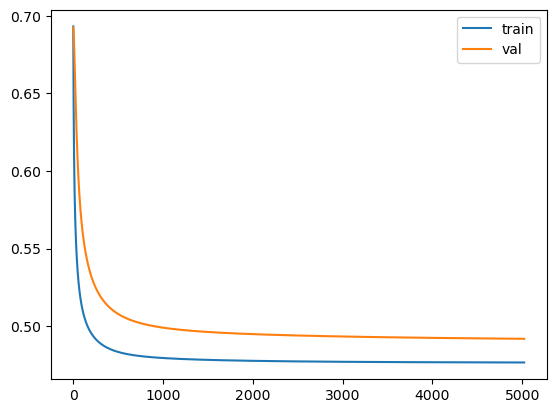

In [368]:
# Plot the train and val losses
plt.plot(losses, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.show()


In [375]:
def prediction(tx_test, w):
    compute = sigmoid(np.dot(tx_test, w))
    y_test = (compute >= 0.725).astype(int)
    return y_test
#Now we test the result: % of well classified data
def percentage_well_predicted(true_labels, predicted_labels):
    # Check if both vectors have the same length
    if len(true_labels) != len(predicted_labels):
        raise ValueError("The two vectors must have the same length.")
    # Calculate the number of wrongly predicted points
    num_right = np.sum(true_labels == predicted_labels)
    # Calculate the percentage of wrongly predicted points
    percentage_right = (num_right / len(true_labels)) * 100
    return percentage_right
tx_val = np.c_[np.ones((X_val.shape[0], 1)), X_val]
print(tx_val.shape)
print(w.shape)
y_pred_test = prediction(tx_val, w)
zero_count = np.sum(y_pred_test == 0)
nonzero_count = np.sum(y_pred_test != 0)
print(zero_count)
print(nonzero_count)
print(percentage_well_predicted(Y_val, y_pred_test))

(32813, 20)
(20, 1)
28363
4450
86.79182031511901


In [376]:
def f1(y_pred, y_true):
    tp = np.sum(y_pred[y_true == 1] == 1)
    fp = np.sum(y_pred[y_true == 0] == 1)
    fn = np.sum(y_pred[y_true == 1] == 0)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

print(f1(y_pred_test, Y_val))

0.4113012768269492


In [377]:
def confusion_matrix(y_pred, y_true):
    tp = np.sum(y_pred[y_true == 1] == 1)
    fp = np.sum(y_pred[y_true == 0] == 1)
    fn = np.sum(y_pred[y_true == 1] == 0)
    tn = np.sum(y_pred[y_true == 0] == 0)
    return tp, fp, fn, tn

tp, fp, fn, tn = confusion_matrix(y_pred_test, Y_val)
print(tp)
print(fp)
print(fn)
print(tn)

1514
2936
1398
26965


In [293]:
np.unique(Y_val, return_counts=True)

(array([0, 1]), array([29830,  2983]))

Now we want to use our w to predict the results: we first format our x_test values

In [294]:
def extract_feature_test(name):
    filename = './dataset/x_test.csv'
    first_line = np.array(read_first_line(filename))
    index = np.where(first_line == name)
    ind = index[0].item()
    return x_test.copy()[:, ind-1]

################Body mass idex - continuous feature
_BMI5 = extract_feature_test('_BMI5')
_BMI5 = replace_mean(_BMI5)
_BMI5, _BMI5_mean, _BMI5_std = standardize(_BMI5)


################High blood pressure - categorical feature (1 = no, 2 = yes, 9 = missing)
_RFHYPE5 = extract_feature_test('_RFHYPE5')
_RFHYPE5[_RFHYPE5 == 9] = np.nan
_RFHYPE5[_RFHYPE5 == 1] = 0
_RFHYPE5[_RFHYPE5 == 2] = 1
_RFHYPE5 = replace_mode(_RFHYPE5)

################High cholesterol - categorical feature (1 = no, 2 = yes, 9 = missing)
_RFCHOL = extract_feature_test('_RFCHOL')
_RFCHOL[_RFCHOL == 9] = np.nan
_RFCHOL[_RFCHOL == 1] = 0
_RFCHOL[_RFCHOL == 2] = 1
_RFCHOL = replace_mode(_RFCHOL)

################Smoking status - categorical feature (1 = every day, 2 = some days, 3 = formerly, 4 = never, 9 = missing)
_SMOKER3 = extract_feature_test('_SMOKER3')
_SMOKER3[_SMOKER3 == 9] = np.nan
_SMOKER3 = replace_mode(_SMOKER3)
_SMOKER3, _SMOKER3_mean, _SMOKER3_std = standardize(_SMOKER3)

################Has ever had a stroke  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
CVDSTRK3 = extract_feature_test('CVDSTRK3')
CVDSTRK3[CVDSTRK3 == 9] = np.nan
CVDSTRK3[CVDSTRK3 == 7] = np.nan
CVDSTRK3[CVDSTRK3 == 2] = 0
CVDSTRK3 = replace_mode(CVDSTRK3)

################Cholesterol checked  - categorical feature (1 = within the last 5 years, 2 = more than 5 years ago, 3 = never, 9 = missing)
_CHOLCHK = extract_feature_test('_CHOLCHK')
_CHOLCHK[_CHOLCHK == 9] = np.nan
_CHOLCHK = replace_mode(_CHOLCHK)
_CHOLCHK,_ , _ = standardize(_CHOLCHK)

################Has ever had diabetes  - categorical feature (1 = yes, 2 = yes*, 3 = no, 4 = no - pre-diabetes, 7 = don't know, 9 = missing)
DIABETE3 = extract_feature_test('DIABETE3')
DIABETE3[DIABETE3 == 9] = np.nan
DIABETE3[DIABETE3 == 7] = np.nan
DIABETE3[DIABETE3 == 3] = 0
DIABETE3[DIABETE3 == 4] = 0
DIABETE3[DIABETE3 == 2] = 1
DIABETE3 = replace_mode(DIABETE3)

################Physical activity index  - categorical feature (1 = highly active, 2 = active, 3 = insufficiently active, 4 = inactive, 9 = missing)
_PACAT1 = extract_feature_test('_PACAT1')
_PACAT1[_PACAT1 == 9] = np.nan
_PACAT1 = replace_mode(_PACAT1)
_PACAT1, _PACAT1_mean, _PACAT1_std = standardize(_PACAT1)

################Total fruits consumed per day  - continuous feature (implied 2 dp)
#_FRUTSUM = extract_feature('_FRUTSUM')

################Total vegetables consumed per day  - continuous feature (implied 2 dp)
#_VEGESUM = extract_feature('_VEGESUM')

################Computed number of drinks of alcohol beverages per week  - continuous feature (99900 = missing)
_DRNKWEK = extract_feature_test('_DRNKWEK')
_DRNKWEK[_DRNKWEK == 99900] = np.nan
_DRNKWEK = replace_mean(_DRNKWEK)
_DRNKWEK, _DRNKWEK_mean, _DRNKWEK_std = standardize(_DRNKWEK)

################Have any healthcare coverage  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
HLTHPLN1 = extract_feature_test('HLTHPLN1')
HLTHPLN1[HLTHPLN1 == 9] = np.nan
HLTHPLN1[HLTHPLN1 == 7] = np.nan
HLTHPLN1[HLTHPLN1 == 2] = 0
HLTHPLN1 = replace_mode(HLTHPLN1)

################Could not see doctor because of cost  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
MEDCOST = extract_feature_test('MEDCOST')
MEDCOST[MEDCOST == 9] = np.nan
MEDCOST[MEDCOST == 7] = np.nan
MEDCOST[MEDCOST == 2] = 0
MEDCOST = replace_mode(MEDCOST)

################General health status  - categorical feature (1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor, 7 = don't know, 9 = missing)
GENHLTH = extract_feature_test('GENHLTH')
GENHLTH[GENHLTH == 9] = np.nan
GENHLTH[GENHLTH == 7] = np.nan
GENHLTH = replace_mode(GENHLTH)
GENHLTH, GENHLTH_mean, GENHLTH_std = standardize(GENHLTH)

################Number of days mental health not good  - continuous feature (88 = none, 77 = don't know, 99 = refused)
MENTHLTH = extract_feature_test('MENTHLTH')
MENTHLTH[MENTHLTH == 88] = 0
MENTHLTH[MENTHLTH == 77] = np.nan
MENTHLTH[MENTHLTH == 99] = np.nan
MENTHLTH = replace_mean(MENTHLTH)
MENTHLTH, MENTHLTH_mean, MENTHLTH_std = standardize(MENTHLTH)

################Number of days physical health not good  - continuous feature (88 = none, 77 = don't know, 99 = refused)
PHYSHLTH = extract_feature_test('PHYSHLTH')
PHYSHLTH[PHYSHLTH == 88] = 0
PHYSHLTH[PHYSHLTH == 77] = np.nan
PHYSHLTH[PHYSHLTH == 99] = np.nan
PHYSHLTH = replace_mean(PHYSHLTH)
PHYSHLTH, PHYSHLTH_mean, PHYSHLTH_std = standardize(PHYSHLTH)

################Difficulty walking or climbing stairs - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
DIFFWALK = extract_feature_test('DIFFWALK')
DIFFWALK[DIFFWALK == 9] = np.nan
DIFFWALK[DIFFWALK == 7] = np.nan
DIFFWALK[DIFFWALK == 2] = 0
DIFFWALK = replace_mode(DIFFWALK)

################Sex - categorical feature (1 = male, 2 = female)
SEX = extract_feature_test('SEX')
SEX[SEX == 2] = 0
SEX = replace_mode(SEX)

################Age  - categorical feature (1 = 18-24, ... 13 = 80+, 14 = missing)
_AGEG5YR = extract_feature_test('_AGEG5YR')
_AGEG5YR[_AGEG5YR == 14] = np.nan
_AGEG5YR = replace_mode(_AGEG5YR)
_AGEG5YR, _AGEG5YR_mean, _AGEG5YR_std = standardize(_AGEG5YR)

################Education  - categorical feature (1 = none, ... 6 = college grad, 9 = missing)
EDUCA = extract_feature_test('EDUCA')
EDUCA[EDUCA == 9] = np.nan
EDUCA = replace_mode(EDUCA)
EDUCA, EDUCA_mean, EDUCA_std = standardize(EDUCA)

################Income level  - categorical feature (1 = low, ... 5 = high, 9 = missing)
_INCOMG = extract_feature_test('_INCOMG')
_INCOMG[_INCOMG == 9] = np.nan
_INCOMG = replace_mode(_INCOMG)
_INCOMG, _INCOMG_mean, _INCOMG_std = standardize(_INCOMG)

#Here we stack the features together to have the our new X
X_test = np.hstack((_BMI5.reshape(-1, 1), _RFHYPE5.reshape(-1, 1), _RFCHOL.reshape(-1, 1), _SMOKER3.reshape(-1, 1), CVDSTRK3.reshape(-1, 1), 
               _CHOLCHK.reshape(-1, 1), DIABETE3.reshape(-1, 1), _PACAT1.reshape(-1, 1), # _FRUTSUM.reshape(-1, 1), _VEGESUM.reshape(-1, 1), 
               _DRNKWEK.reshape(-1, 1), HLTHPLN1.reshape(-1, 1), MEDCOST.reshape(-1, 1), GENHLTH.reshape(-1, 1), MENTHLTH.reshape(-1, 1), PHYSHLTH.reshape(-1, 1), 
               DIFFWALK.reshape(-1, 1), SEX.reshape(-1, 1), _AGEG5YR.reshape(-1, 1), EDUCA.reshape(-1, 1), _INCOMG.reshape(-1, 1)))


Now we actually want to predict

In [295]:
def prediction(tx_test, w):
    compute = sigmoid(np.dot(tx_test, w))
    y_test = (compute >= 0.745).astype(int)
    return y_test

In [296]:
tx_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
print(tx_test)
print(w)
y_pred = prediction(tx_test, w)
print(y_pred)
nonzero_count = np.sum(y_pred != 0)
zero_count = np.sum(y_pred == 0)
print(nonzero_count)
print(zero_count)
y_pred[y_pred == 0] = -1

[[ 1.00000000e+00 -9.09070615e-01  1.00000000e+00 ...  1.54082763e+00
   1.04300780e+00  7.41110652e-01]
 [ 1.00000000e+00 -9.67684643e-01  0.00000000e+00 ... -1.96329906e+00
   1.04300780e+00  7.41110652e-01]
 [ 1.00000000e+00  1.68842320e-15  1.00000000e+00 ...  6.64795955e-01
   1.04300780e+00  7.41110652e-01]
 ...
 [ 1.00000000e+00 -5.13029881e-01  0.00000000e+00 ...  1.54082763e+00
   1.04300780e+00 -6.82577255e-01]
 [ 1.00000000e+00 -6.41347079e-01  0.00000000e+00 ...  1.54082763e+00
   8.50664592e-02  7.41110652e-01]
 [ 1.00000000e+00  2.24024530e+00  1.00000000e+00 ... -5.03246272e-01
   8.50664592e-02  7.41110652e-01]]
[[-1.78423124]
 [ 0.01389102]
 [ 0.58075042]
 [ 0.60970256]
 [-0.15791858]
 [ 1.13637823]
 [-0.15074227]
 [ 0.33664388]
 [-0.03881138]
 [-0.03505274]
 [-0.12487966]
 [ 0.23971086]
 [ 0.50706202]
 [ 0.0463565 ]
 [ 0.04574768]
 [ 0.32519807]
 [ 0.76750007]
 [ 0.89856254]
 [-0.02532965]
 [-0.07812793]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
13390
95989


In [297]:
from helpers import create_csv_submission
create_csv_submission(test_ids, y_pred, "Submission_7")

In [298]:
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([95989, 13390]))